In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from prophet import Prophet
import warnings
import math
from math import sqrt
import time
warnings.filterwarnings("ignore")

## 1. Load consumption data


|Data                |Granularity |Year range|Source |
|--------------------|------------|----------|-------|
|Load consumption    |hourly      |2006-2023 |ENTSO-E|

In [2]:
# Load the dataset to explore trends and patterns
data_path = 'loadConsumption/data_2006_2023.csv'
data = pd.read_csv(data_path)

# Display basic information about the dataset
data.info(), data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157772 entries, 0 to 157771
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   loadConsumption  157772 non-null  float64
 1   date             157772 non-null  object 
 2   datetime         157772 non-null  object 
 3   Hour             157772 non-null  int64  
 4   Year             157772 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 6.0+ MB


(None,
    loadConsumption        date             datetime  Hour  Year
 0          10215.0  2006-01-01  2005-12-31 23:00:00     0  2006
 1           9979.0  2006-01-01  2006-01-01 00:00:00     1  2006
 2           9460.0  2006-01-01  2006-01-01 01:00:00     2  2006
 3           8833.0  2006-01-01  2006-01-01 02:00:00     3  2006
 4           8525.0  2006-01-01  2006-01-01 03:00:00     4  2006)

In [3]:
# Convert 'datetime' to pandas datetime for time-series operations
data['datetime'] = pd.to_datetime(data['datetime'])


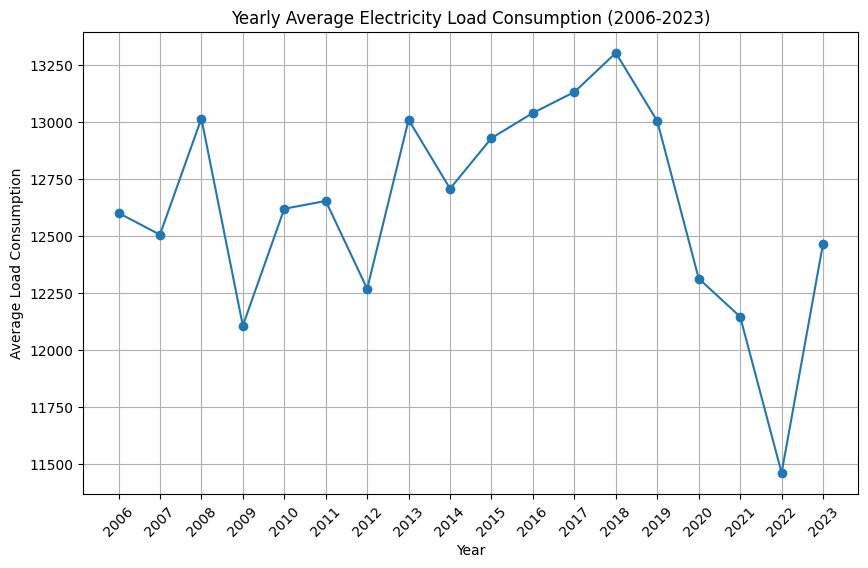

In [4]:
# Aggregate data for yearly trends
yearly_data = data.groupby('Year')['loadConsumption'].mean()

# Plot yearly trends
plt.figure(figsize=(10, 6))
plt.plot(yearly_data.index, yearly_data.values, marker='o')
plt.xticks(yearly_data.index, rotation=45)  
plt.title('Yearly Average Electricity Load Consumption (2006-2023)')
plt.xlabel('Year')
plt.ylabel('Average Load Consumption')
plt.grid()
plt.show()


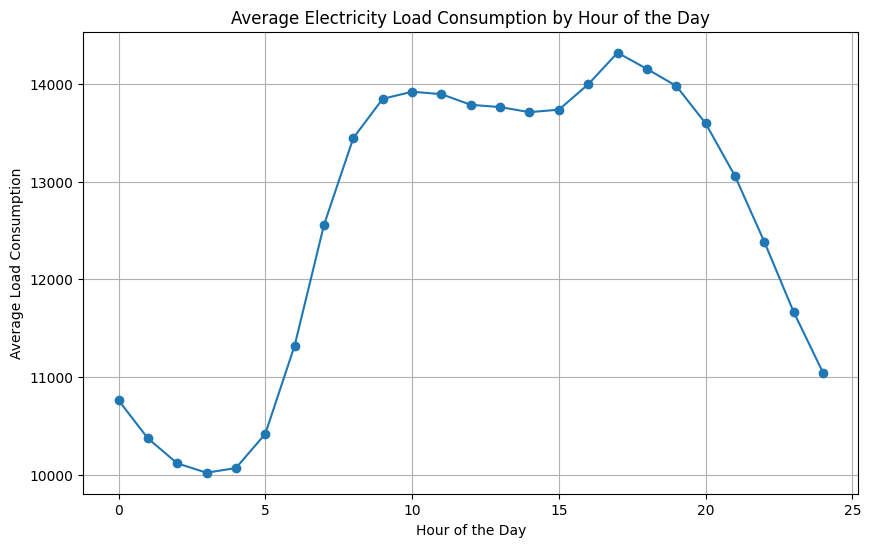

In [5]:
# Hourly patterns
hourly_data = data.groupby('Hour')['loadConsumption'].mean()

# Plot hourly trends
plt.figure(figsize=(10, 6))
plt.plot(hourly_data.index, hourly_data.values, marker='o')
plt.title("Average Electricity Load Consumption by Hour of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Average Load Consumption")
plt.grid()
plt.show()

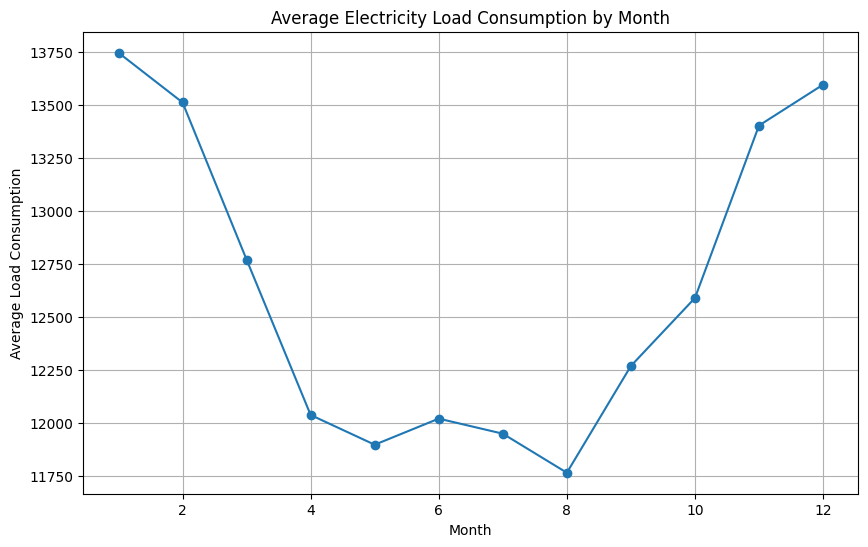

In [6]:
# Monthly patterns by extracting the month
data['Month'] = data['datetime'].dt.month
monthly_data = data.groupby('Month')['loadConsumption'].mean()

# Plot monthly trends
plt.figure(figsize=(10, 6))
plt.plot(monthly_data.index, monthly_data.values, marker='o')
plt.title("Average Electricity Load Consumption by Month")
plt.xlabel("Month")
plt.ylabel("Average Load Consumption")
plt.grid()
plt.show()

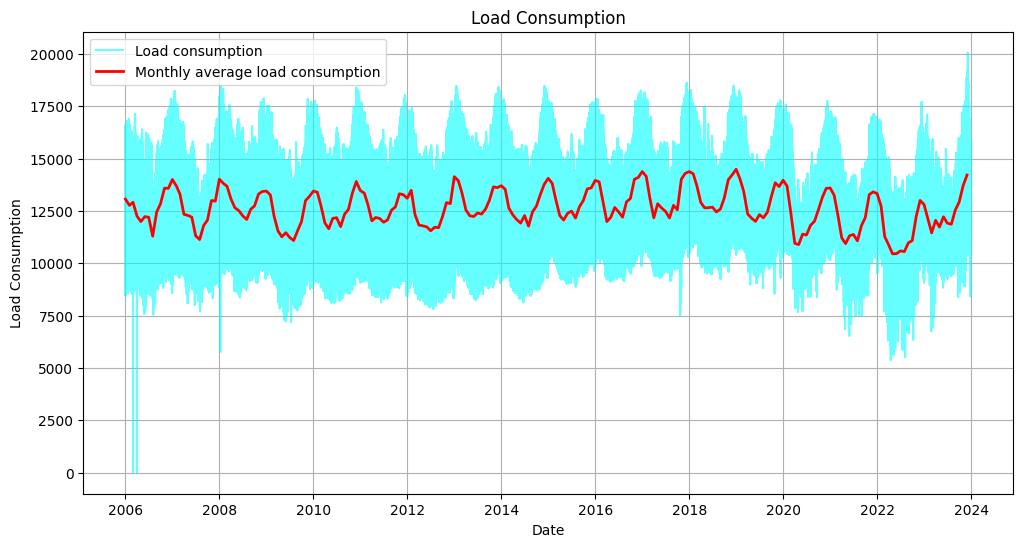

In [7]:
# Convert 'date' column to datetime if not already
data['date'] = pd.to_datetime(data['date'])

# Aggregate data for monthly average
data['Month'] = data['date'].dt.to_period('M')
monthly_data = data.groupby('Month')['loadConsumption'].mean()

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['loadConsumption'], color='cyan', label='Load consumption', alpha=0.6)
plt.plot(monthly_data.index.to_timestamp(), monthly_data.values, color='red', linewidth=2, label='Monthly average load consumption')

# Add title and labels
plt.title('Load Consumption')
plt.xlabel('Date')
plt.ylabel('Load Consumption')
plt.legend()
plt.grid()
plt.show()


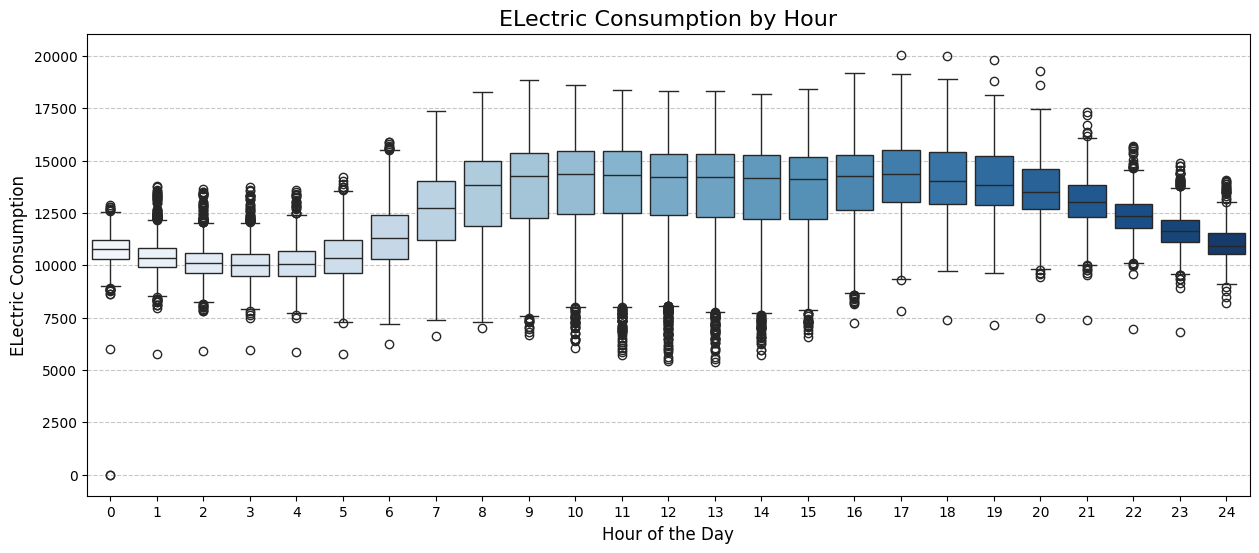

In [8]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(data=data, x='Hour', y='loadConsumption', palette='Blues')
ax.set_title('ELectric Consumption by Hour', fontsize=16)
ax.set_xlabel('Hour of the Day', fontsize=12)
ax.set_ylabel('ELectric Consumption', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

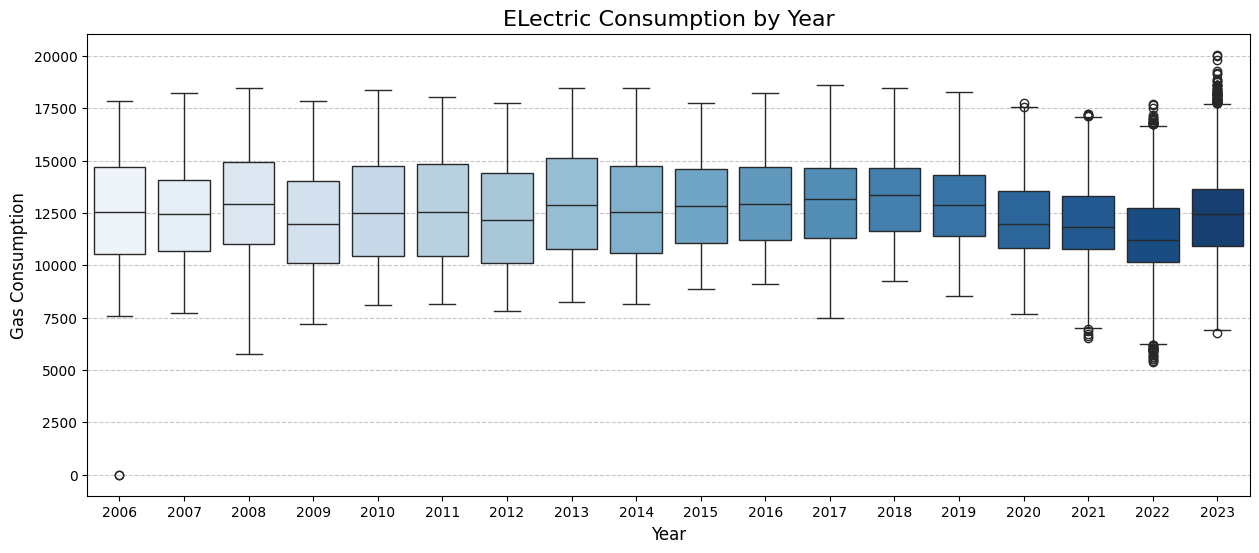

In [9]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(data=data, x='Year', y='loadConsumption', palette='Blues')
ax.set_title('ELectric Consumption by Year', fontsize=16)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Gas Consumption', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [10]:
# Function to assign seasons based on the month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

# Add a 'Season' as a column
data['Month'] = data['datetime'].dt.month  
data['Season'] = data['Month'].apply(get_season)  #


data.head()


,loadConsumption,date,datetime,Hour,Year,Month,Season
0,10215.0,2006-01-01,2005-12-31 23:00:00,0,2006,12,Winter
1,9979.0,2006-01-01,2006-01-01 00:00:00,1,2006,1,Winter
2,9460.0,2006-01-01,2006-01-01 01:00:00,2,2006,1,Winter
3,8833.0,2006-01-01,2006-01-01 02:00:00,3,2006,1,Winter
4,8525.0,2006-01-01,2006-01-01 03:00:00,4,2006,1,Winter


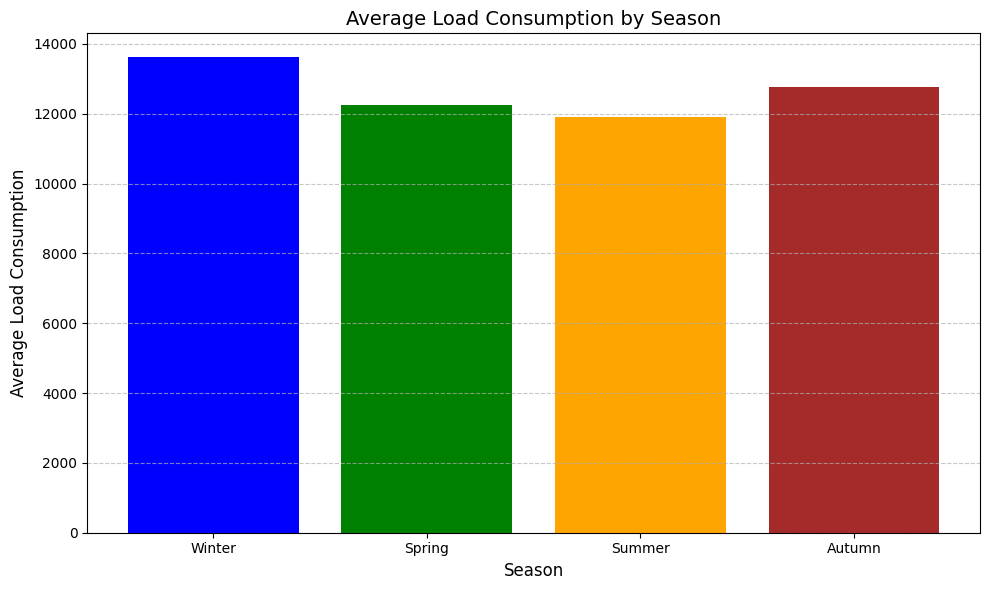

In [11]:
# Aggregate data by season and calculate the mean load consumption for each season
seasonal_data = data.groupby('Season')['loadConsumption'].mean()

# Sort the seasons in a logical order for visualization
season_order = ['Winter', 'Spring', 'Summer', 'Autumn']
seasonal_data = seasonal_data.reindex(season_order)

# Plot the seasonal trends
plt.figure(figsize=(10, 6))
plt.bar(seasonal_data.index, seasonal_data.values, color=['blue', 'green', 'orange', 'brown'])
plt.title('Average Load Consumption by Season', fontsize=14)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Average Load Consumption', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [12]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import shapiro

def check_normality(df, feature):
    plt.figure(figsize=(6, 6))

    # histogram
    plt.hist(df[feature], edgecolor='black', bins=20)
    plt.title(f'Histogram of {feature}')

    # qq plot
    sm.qqplot(df[feature], line='45')
    plt.title(f'QQ plot of {feature}')

    plt.tight_layout()

    plt.show()

    # shapiro wilk
    print(shapiro(df[feature]))


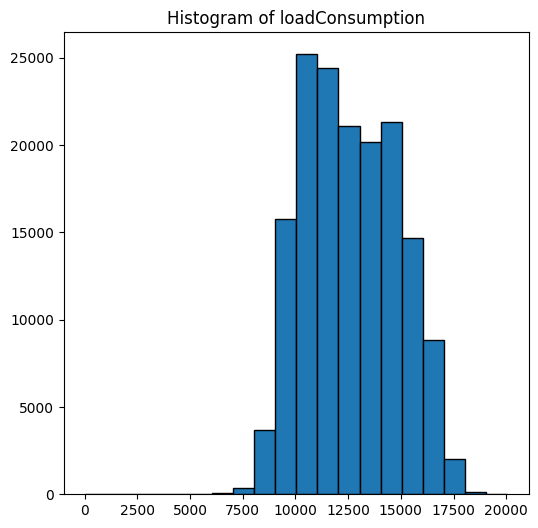

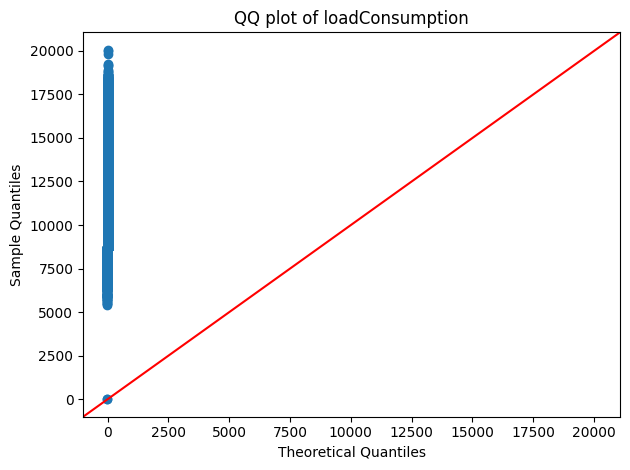

ShapiroResult(statistic=0.9795600771903992, pvalue=0.0)


In [13]:
check_normality(df=data, feature='loadConsumption')

In [14]:
data.isna().sum() / len(data)

loadConsumption    0.0
date               0.0
datetime           0.0
Hour               0.0
Year               0.0
Month              0.0
Season             0.0
dtype: float64

## 2. KNMI weather data

The KNMI dataset contains lots of weather related variables. The column names are abbreviations, which we replace with full names. We select data from 2021 and on because that is the start date of our research. We cast some columns to the right format.

We choose these predictors from the dataset

|Abbreviation|Full name                 |Description                                                       |
|------------|--------------------------|------------------------------------------------------------------|
|YYYYMMDD    |Date                      | Date (YYYY=year MM=month DD=day)                                 |
|RH          |DailyPrecipitation        | Daily precipitation amount (in 0.1 mm) (-1 for <0.05 mm)         |
|RHX         |MaxHourlyPrecipitation    | Maximum hourly precipitation amount (in 0.1 mm) (-1 for <0.05 mm)|
|RHXH        |HDMaxPrecipitation*       | Hourly division in which RHX was measured                        |
|TG          |DailyMeanTemperature      | Daily mean temperature in (0.1 degrees Celsius)                  |
|TN          |HourlyMinTemperature      | Minimum temperature (in 0.1 degrees Celsius)                     |
|TNH         |HDMinTemperature*         | Hourly division in which TN was measured                         |
|TX          |HourlyMaxTemperature      | Maximum temperature (in 0.1 degrees Celsius)                     |
|TXH         |HDMaxTemperature*         | Hourly division in which TX was measured                         |
|FG          |DailyMeanWindspeed        | Daily mean windspeed (in 0.1 m/s)                                |
|FHN         |HourlyMinMeanWindspeed    | Minimum hourly mean windspeed (in 0.1 m/s)                       |
|FHNH        |HDMinMeanWindspeed*       | Hourly division in which FHN was measured                        |
|FHX         |HourlyMaxMeanWindspeed    | Maximum hourly mean windspeed (in 0.1 m/s)                       |
|FHXH        |HDMaxMeanWindspeed*       | Hourly division in which FHX was measured                        |

Where * HD = Hourly Division

In [15]:
def read_data(path: str) -> pd.DataFrame:
    """
    Read the data.
    Strip spaces from the columns.
    Rename all the columns (abbreviations -> full names).
    """

    weather = pd.read_csv(path)

    weather.columns = weather.columns.str.strip()
    weather = weather.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    weather.replace('', None, inplace=True)

    column_mapping = {
        'YYYYMMDD': 'Date',
        'RH': 'DailyPrecipitation',
        'RHX': 'MaxHourlyPrecipitation',
        'RHXH': 'HDMaxPrecipitation',
        'TG': 'DailyMeanTemperature',
        'TN': 'HourlyMinTemperature',
        'TNH': 'HDMinTemperature',
        'TX': 'HourlyMaxTemperature',
        'TXH': 'HDMaxTemperature',
        'FG': 'DailyMeanWindspeed',
        'FHX': 'MaxHourlyMeanWindspeed',
        'FHXH': 'HDMaxMeanWindspeed',
        'FHN': 'MinHourlyMeanWindspeed',
        'FHNH': 'HDMinMeanWindspeed'
    }

    weather = weather[column_mapping.keys()]
    weather.rename(columns=column_mapping, inplace=True)

    return weather


def filter_on_year(weather: pd.DataFrame) -> pd.DataFrame:
    """
    Filter on only 1995 and later and reset index after filtering.
    """
    weather = weather[weather['Date'] >= 19950101]
    weather.reset_index(drop=True, inplace=True)

    return weather


def cast_datekey(weather: pd.DataFrame) -> pd.DataFrame:
    """
    Cast datekey 19950101 to format 1995/01/01
    """
    weather['Date'] = pd.to_datetime(weather['Date'], format='%Y%m%d').dt.strftime('%Y/%m/%d')

    return weather


def cast_hour_columns(weather: pd.DataFrame) -> pd.DataFrame:
    """
    Cast hour columns to integer.
    """
    hour_cols = [
        'HDMaxPrecipitation',
        'HDMinTemperature',
        'HDMaxTemperature',
        'HDMaxMeanWindspeed',
        'HDMinMeanWindspeed'
    ]

    for i in hour_cols:
        weather[i] = weather[i].astype(int)

    return weather


def convert_columns(weather: pd.DataFrame) -> pd.DataFrame:
    """
    Divide the following columns by 10 to get actual number, since they are 0.1 of the actual number.
    """
    cols_to_convert = [
        'DailyPrecipitation',
        'MaxHourlyPrecipitation',
        'DailyMeanTemperature',
        'HourlyMaxTemperature',
        'DailyMeanWindspeed',
        'MinHourlyMeanWindspeed',
        'MaxHourlyMeanWindspeed'
    ]
    for i in cols_to_convert:
        weather[i] = weather[i] / 10

    return weather


def create_date_columns(weather: pd.DataFrame) -> pd.DataFrame:
    """
    Cast date column (2021-01-01 instead of 2021/01/01) and add month and year columns
    Create a week key combining year and week number
    """
    weather['Date'] = pd.to_datetime(weather['Date'], format='%Y/%m/%d')
    weather['Month'] = weather['Date'].dt.month
    weather['Year'] = weather['Date'].dt.year
    weather['Week'] = weather['Date'].dt.isocalendar().week

    weather['WeekKey'] = weather['Year'].astype(str) + weather['Week'].apply(lambda x: '{:02d}'.format(x))
    weather['day_of_week'] = weather['Date'].dt.day_name()

    return weather


def preprocess_weather(path: str) -> pd.DataFrame:
    """
    Preprocess the weather data.
    """
    weather = read_data(path)
    weather = filter_on_year(weather)
    weather = cast_datekey(weather)
    weather = cast_hour_columns(weather)
    weather = convert_columns(weather)
    weather = create_date_columns(weather)

    return weather

In [16]:
weather_path = 'deBilt.csv'

weather = preprocess_weather(weather_path)

weather

,Date,DailyPrecipitation,MaxHourlyPrecipitation,HDMaxPrecipitation,DailyMeanTemperature,HourlyMinTemperature,HDMinTemperature,HourlyMaxTemperature,HDMaxTemperature,DailyMeanWindspeed,MaxHourlyMeanWindspeed,HDMaxMeanWindspeed,MinHourlyMeanWindspeed,HDMinMeanWindspeed,Month,Year,Week,WeekKey,day_of_week
0,1995-01-01,8.3,1.7,12,2.0,2,14,3.8,19,4.6,7.7,20,2.6,1,1,1995,52,199552,Sunday
1,1995-01-02,3.2,1.2,4,3.0,-12,24,5.9,12,4.6,7.7,7,1.0,24,1,1995,1,199501,Monday
2,1995-01-03,-0.1,-0.1,3,-0.5,-38,24,2.3,14,2.1,3.1,12,1.0,1,1,1995,1,199501,Tuesday
3,1995-01-04,0.0,0.0,1,-2.8,-48,21,0.3,14,2.6,4.1,14,2.1,1,1,1995,1,199501,Wednesday
4,1995-01-05,0.0,0.0,1,-3.9,-59,8,-1.8,14,5.7,7.7,21,3.1,1,1,1995,1,199501,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10968,2025-01-11,-0.1,-0.1,1,0.5,-45,8,5.8,14,1.5,3.0,14,0.0,7,1,2025,2,202502,Saturday
10969,2025-01-12,0.1,0.1,21,1.7,-6,22,6.0,14,1.2,2.0,5,1.0,1,1,2025,2,202502,Sunday
10970,2025-01-13,0.0,0.0,1,0.5,-33,5,5.2,14,2.2,4.0,13,1.0,1,1,2025,3,202503,Monday
10971,2025-01-14,0.1,0.1,20,2.8,-16,1,5.7,24,3.1,5.0,13,2.0,6,1,2025,3,202503,Tuesday


In [17]:
weather.isna().sum() / len(weather)

Date                      0.0
DailyPrecipitation        0.0
MaxHourlyPrecipitation    0.0
HDMaxPrecipitation        0.0
DailyMeanTemperature      0.0
HourlyMinTemperature      0.0
HDMinTemperature          0.0
HourlyMaxTemperature      0.0
HDMaxTemperature          0.0
DailyMeanWindspeed        0.0
MaxHourlyMeanWindspeed    0.0
HDMaxMeanWindspeed        0.0
MinHourlyMeanWindspeed    0.0
HDMinMeanWindspeed        0.0
Month                     0.0
Year                      0.0
Week                      0.0
WeekKey                   0.0
day_of_week               0.0
dtype: float64

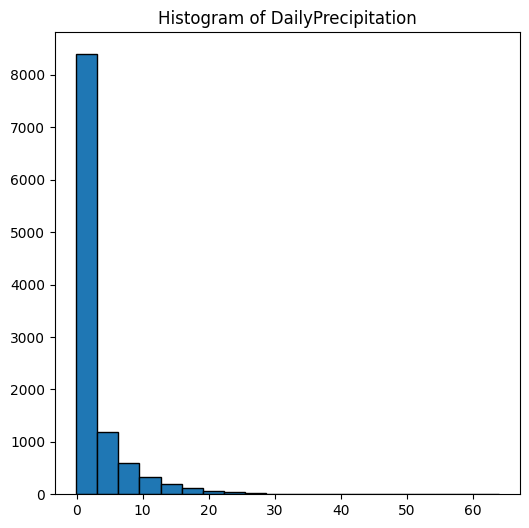

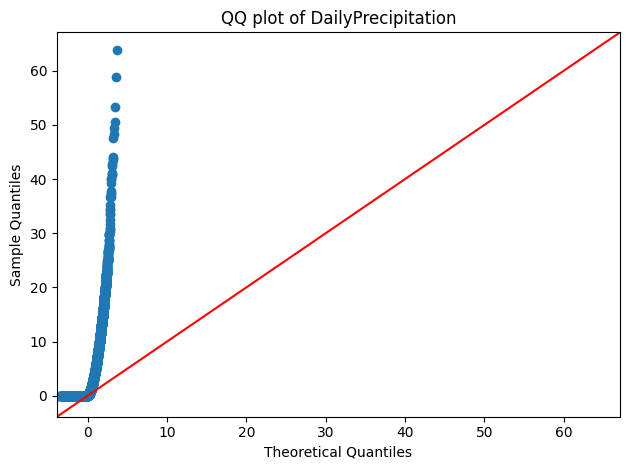

ShapiroResult(statistic=0.567188024520874, pvalue=0.0)


In [18]:
check_normality(df=weather, feature='DailyPrecipitation')

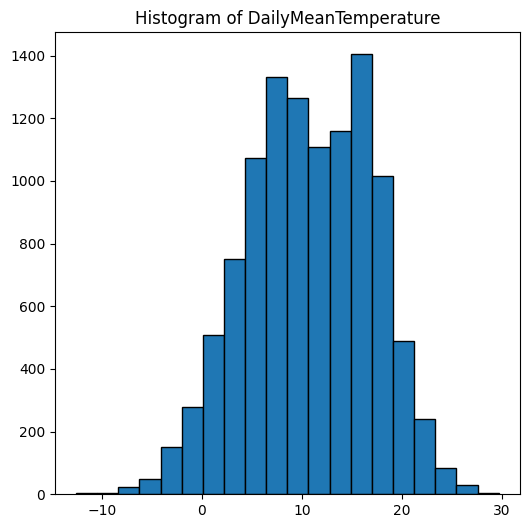

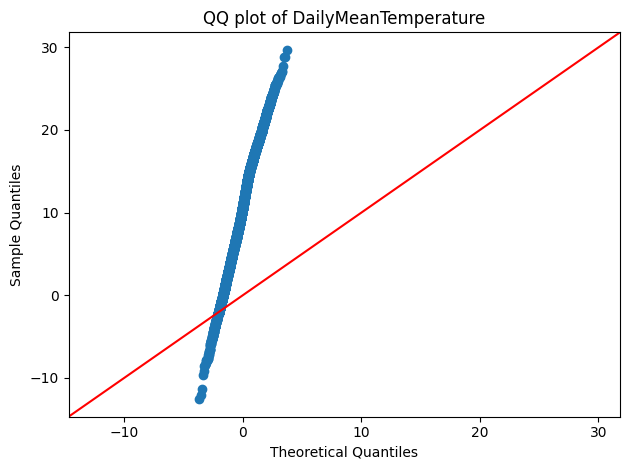

ShapiroResult(statistic=0.9928660988807678, pvalue=5.883746198406056e-23)


In [19]:
check_normality(df=weather, feature='DailyMeanTemperature')

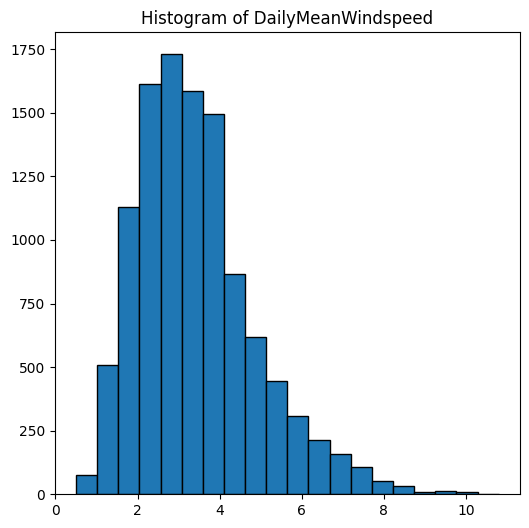

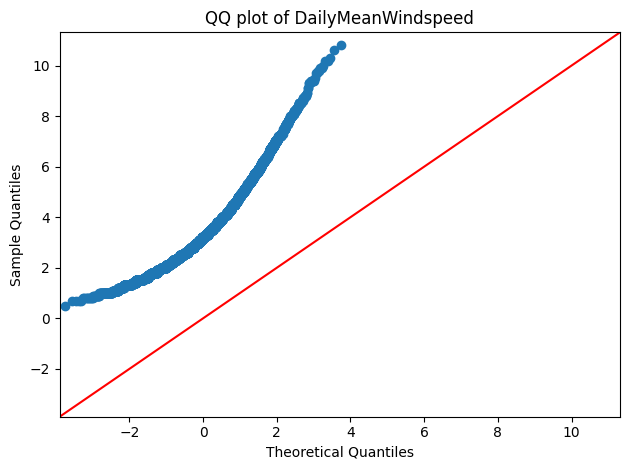

ShapiroResult(statistic=0.9450923800468445, pvalue=0.0)


In [20]:
check_normality(df=weather, feature='DailyMeanWindspeed')

## 3. NAO index

The NAO index dataset contains data from 1950 and on. It has a row for each year, where the columns are the 12 months. We melt the dataset because we want a Year-Month combination on each row. 

In [21]:
def preprocess_nao(path: str) -> pd.DataFrame:
    """
    Reset index, index is now the year and we want this as a column.
    Melt the dataset into a year, month and NAO column.
    Rename index to Year.
    Map the months (now strings) to corresponding month numbers.
    """
    nao = pd.read_csv(path, delim_whitespace=True, index_col=0)
    nao.reset_index(inplace=True)
    nao_melted = pd.melt(nao, id_vars=['index'], var_name='Month', value_name='NAO')
    nao_melted.rename(columns={'index':'Year'}, inplace=True)
    month_mapping = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
                 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
    nao_melted['Month'] = nao_melted['Month'].map(month_mapping)

    return nao_melted

In [22]:
NAO_file_path = 'NAO.txt'
nao = preprocess_nao(NAO_file_path)


In [23]:
nao

,Year,Month,NAO
0,1950,1,0.92
1,1951,1,0.08
2,1952,1,0.93
3,1953,1,0.33
4,1954,1,0.37
...,...,...,...
895,2020,12,-0.30
896,2021,12,0.29
897,2022,12,-0.15
898,2023,12,1.94


In [24]:
nao = nao[nao['Year'] >= 1995]

In [25]:
nao

,Year,Month,NAO
45,1995,1,0.93
46,1996,1,-0.12
47,1997,1,-0.49
48,1998,1,0.39
49,1999,1,0.77
...,...,...,...
895,2020,12,-0.30
896,2021,12,0.29
897,2022,12,-0.15
898,2023,12,1.94


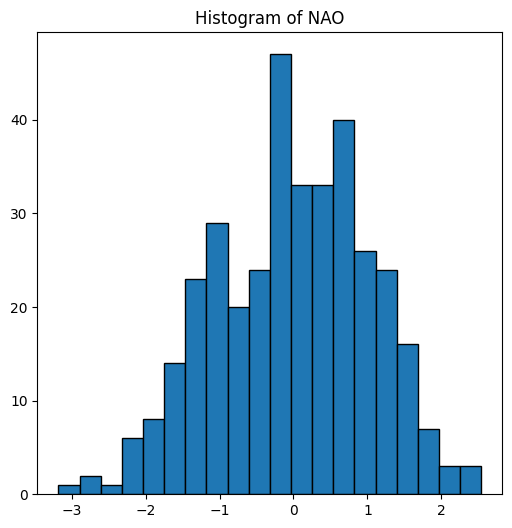

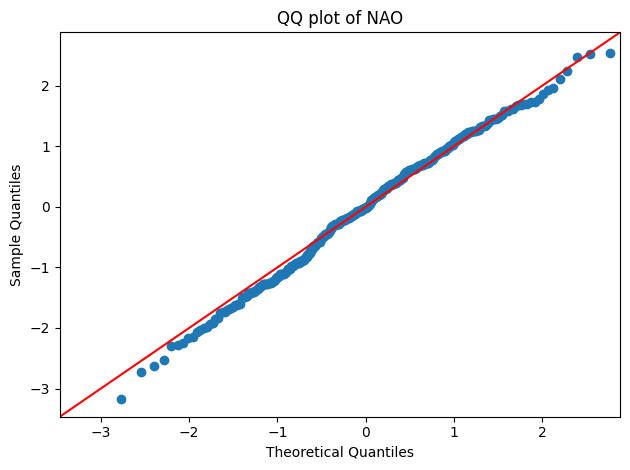

ShapiroResult(statistic=0.9935696721076965, pvalue=0.12938439846038818)


In [26]:
check_normality(df=nao, feature='NAO')

In [27]:
nao.isna().sum() / len(nao)

Year     0.0
Month    0.0
NAO      0.0
dtype: float64

## Energy Prices

In [38]:
energyPrice_path = 'energyConsPricesNl2009.csv'
energyPriceNl = pd.read_csv(energyPrice_path, delimiter=';')

#energyPriceNl.columns.tolist()


In [39]:
# Mapping of Dutch column names to English translations
column_mapping = {
    'Prijscomponenten': 'Price_Components',
    'Belastingen': 'Taxes',
    'Perioden': 'Periods',
    'Aardgasprijs/Verbruiksklassen huishoudens/Minder dan 569 m3 (euro per m3)': 'NaturalGasPrice_Households_LessThan_569m3_EuroPerM3',
    'Aardgasprijs/Verbruiksklassen huishoudens/569 tot 5 687 m3 (euro per m3)': 'NaturalGasPrice_Households_569to5687m3_EuroPerM3',
    'Aardgasprijs/Verbruiksklassen huishoudens/5 687 m3 en meer (euro per m3)': 'NaturalGasPrice_Households_MoreThan_5687m3_EuroPerM3',
    'Aardgasprijs/Verbruiksklassen niet-huishoudens/Minder dan 28 433 m3 (euro per m3)': 'NaturalGasPrice_NonHouseholds_LessThan_28433m3_EuroPerM3',
    'Aardgasprijs/Verbruiksklassen niet-huishoudens/28 433 tot 284 333 m3 (euro per m3)': 'NaturalGasPrice_NonHouseholds_28433to284333m3_EuroPerM3',
    'Aardgasprijs/Verbruiksklassen niet-huishoudens/284 333 tot 2 843 332 m3 (euro per m3)': 'NaturalGasPrice_NonHouseholds_284333to2843332m3_EuroPerM3',
    'Aardgasprijs/Verbruiksklassen niet-huishoudens/2 843 332 tot 28 433 324 m3 (euro per m3)': 'NaturalGasPrice_NonHouseholds_2843332to28433324m3_EuroPerM3',
    'Aardgasprijs/Verbruiksklassen niet-huishoudens/28 433 324 m3 en meer (euro per m3)': 'NaturalGasPrice_NonHouseholds_MoreThan_28433324m3_EuroPerM3',
    'Elektriciteitsprijs /Verbruiksklassen huishoudens/Minder dan 1 MWh (euro per kWh)': 'ElectricityPrice_Households_LessThan_1MWh_EuroPerKWh',
    'Elektriciteitsprijs /Verbruiksklassen huishoudens/1 tot 2,5 MWh (euro per kWh)': 'ElectricityPrice_Households_1to2.5MWh_EuroPerKWh',
    'Elektriciteitsprijs /Verbruiksklassen huishoudens/2,5 tot 5 MWh (euro per kWh)': 'ElectricityPrice_Households_2.5to5MWh_EuroPerKWh',
    'Elektriciteitsprijs /Verbruiksklassen huishoudens/5 tot 15 MWh (euro per kWh)': 'ElectricityPrice_Households_5to15MWh_EuroPerKWh',
    'Elektriciteitsprijs /Verbruiksklassen huishoudens/15 MWh en meer (euro per kWh)': 'ElectricityPrice_Households_MoreThan_15MWh_EuroPerKWh',
    'Elektriciteitsprijs /Verbruiksklassen niet-huishoudens/Minder dan 20 MWh (euro per kWh)': 'ElectricityPrice_NonHouseholds_LessThan_20MWh_EuroPerKWh',
    'Elektriciteitsprijs /Verbruiksklassen niet-huishoudens/20 tot 500 MWh (euro per kWh)': 'ElectricityPrice_NonHouseholds_20to500MWh_EuroPerKWh',
    'Elektriciteitsprijs /Verbruiksklassen niet-huishoudens/500 tot 2 000 MWh (euro per kWh)': 'ElectricityPrice_NonHouseholds_500to2000MWh_EuroPerKWh',
    'Elektriciteitsprijs /Verbruiksklassen niet-huishoudens/2 000 tot 20 000 MWh (euro per kWh)': 'ElectricityPrice_NonHouseholds_2000to20000MWh_EuroPerKWh',
    'Elektriciteitsprijs /Verbruiksklassen niet-huishoudens/20 000 tot 70 000 MWh (euro per kWh)': 'ElectricityPrice_NonHouseholds_20000to70000MWh_EuroPerKWh',
    'Elektriciteitsprijs /Verbruiksklassen niet-huishoudens/70 000 tot 150 000 MWh (euro per kWh)': 'ElectricityPrice_NonHouseholds_70000to150000MWh_EuroPerKWh',
    'Elektriciteitsprijs /Verbruiksklassen niet-huishoudens/150 000 MWh en meer (euro per kWh)': 'ElectricityPrice_NonHouseholds_MoreThan_150000MWh_EuroPerKWh'
}

# Apply the column mapping to rename columns
energyPriceNl.rename(columns=column_mapping, inplace=True)

# Display the renamed columns
energyPriceNl.head()


,Price_Components,Taxes,Periods,NaturalGasPrice_Households_LessThan_569m3_EuroPerM3,NaturalGasPrice_Households_569to5687m3_EuroPerM3,NaturalGasPrice_Households_MoreThan_5687m3_EuroPerM3,NaturalGasPrice_NonHouseholds_LessThan_28433m3_EuroPerM3,NaturalGasPrice_NonHouseholds_28433to284333m3_EuroPerM3,NaturalGasPrice_NonHouseholds_284333to2843332m3_EuroPerM3,NaturalGasPrice_NonHouseholds_2843332to28433324m3_EuroPerM3,...,ElectricityPrice_Households_2.5to5MWh_EuroPerKWh,ElectricityPrice_Households_5to15MWh_EuroPerKWh,ElectricityPrice_Households_MoreThan_15MWh_EuroPerKWh,ElectricityPrice_NonHouseholds_LessThan_20MWh_EuroPerKWh,ElectricityPrice_NonHouseholds_20to500MWh_EuroPerKWh,ElectricityPrice_NonHouseholds_500to2000MWh_EuroPerKWh,ElectricityPrice_NonHouseholds_2000to20000MWh_EuroPerKWh,ElectricityPrice_NonHouseholds_20000to70000MWh_EuroPerKWh,ElectricityPrice_NonHouseholds_70000to150000MWh_EuroPerKWh,ElectricityPrice_NonHouseholds_MoreThan_150000MWh_EuroPerKWh
0,Totaalprijs,Inclusief btw en belastingen,2009 1e halfjaar,1.057,0.791,0.722,0.752,0.662,0.459,0.374,...,0.198,0.216,0.257,0.212,0.187,0.132,0.118,0.108,0.104,0.080
1,Totaalprijs,Inclusief btw en belastingen,2009 2e halfjaar,1.031,0.658,0.572,0.622,0.612,0.407,0.330,...,0.190,0.209,0.205,0.211,0.147,0.127,0.116,0.099,0.094,0.072
2,Totaalprijs,Inclusief btw en belastingen,2009,1.045,0.735,0.656,0.706,0.644,0.435,0.352,...,0.195,0.213,0.232,0.211,0.167,0.129,0.117,0.104,0.098,0.076
3,Totaalprijs,Inclusief btw en belastingen,2010 1e halfjaar,0.943,0.664,0.593,0.621,0.545,0.390,0.296,...,0.177,0.196,0.237,0.211,0.175,0.120,0.106,0.091,0.087,0.074
4,Totaalprijs,Inclusief btw en belastingen,2010 2e halfjaar,1.060,0.703,0.608,0.621,0.590,0.360,0.302,...,0.179,0.197,0.189,0.198,0.134,0.115,0.106,0.085,0.086,0.076


In [40]:
energyPriceNl.to_csv('energyPriceNL.csv', index = False)

In [43]:
def ingest_energy_prices(energy_prices: pd.DataFrame) -> pd.DataFrame:
    """
    Prepare data: Clean column names and filter out unnecessary rows.
    """
    # Filter out rows where 'Price_Components' contains irrelevant data
    energy_prices = energy_prices[~energy_prices['Price_Components'].isin(['Totaalprijs'])]

    # Reset index after filtering
    energy_prices.reset_index(drop=True, inplace=True)

    return energy_prices


def drop_years(energy_prices: pd.DataFrame) -> pd.DataFrame:
    """
    Remove rows with only years (e.g., '2009') in the 'Periods' column.
    """
    unique_values = energy_prices['Periods'].unique()
    values_to_select = [val for val in unique_values if len(val.split()) > 1]

    energy_prices = energy_prices[energy_prices['Periods'].isin(values_to_select)]

    return energy_prices


def cast_year_month_col(energy_prices: pd.DataFrame) -> pd.DataFrame:
    """
    Extract and process year and month from the 'Periods' column.
    Remove rows for the year 2023. Ensure Year and Month are integers.
    """
    month_mapping = {
        '1e': "01", '2e': "07"  # Assuming 'halfjaar' maps to January and July
    }

    # Extract year and map months
    energy_prices['Year'] = energy_prices['Periods'].apply(lambda x: int(x.split()[0]))
    energy_prices['Month'] = energy_prices['Periods'].apply(
        lambda x: int(month_mapping.get(x.split()[1], "01")) if len(x.split()) > 1 else 1
    )

    # Remove rows for 2023
    energy_prices = energy_prices[energy_prices['Year'] != 2023]

    # Combine Year and Month into a numeric MonthYear column
    energy_prices['MonthYear'] = energy_prices['Year'] * 100 + energy_prices['Month']

    # Drop the 'Periods' column and set 'MonthYear' as the index
    energy_prices.drop('Periods', axis=1, inplace=True)
    energy_prices.set_index('MonthYear', inplace=True)

    return energy_prices



def cast_cols_to_decimal(energy_prices: pd.DataFrame) -> pd.DataFrame:
    """
    Cast all numeric columns to decimal.
    """
    numeric_cols = energy_prices.select_dtypes(include=['object', 'string']).columns
    for col in numeric_cols:
        try:
            energy_prices[col] = energy_prices[col].str.replace(',', '.').astype(float)
        except ValueError:
            # Skip non-numeric columns
            pass

    return energy_prices


def select_columns(energy_prices: pd.DataFrame) -> pd.DataFrame:
    """
    Select only the columns we wish to keep.
    """
    cols_to_select = [
        'NaturalGasPrice_Households_LessThan_569m3_EuroPerM3',
        'NaturalGasPrice_Households_569to5687m3_EuroPerM3',
        'NaturalGasPrice_Households_MoreThan_5687m3_EuroPerM3',
        'ElectricityPrice_Households_2.5to5MWh_EuroPerKWh',
        'ElectricityPrice_Households_5to15MWh_EuroPerKWh',
        'ElectricityPrice_Households_MoreThan_15MWh_EuroPerKWh',
        'Year', 'Month'
    ]

    energy_prices = energy_prices[cols_to_select]
    return energy_prices


def preprocess_energy_price(energy_prices: pd.DataFrame) -> pd.DataFrame:
    """
    Complete preprocessing pipeline for energy prices.
    """
    energy_prices_ingested = ingest_energy_prices(energy_prices)
    energy_prices_filtered = drop_years(energy_prices_ingested)
    energy_prices_month_year = cast_year_month_col(energy_prices_filtered)
    energy_prices_casted = cast_cols_to_decimal(energy_prices_month_year)
    energy_prices_selected = select_columns(energy_prices_casted)

    return energy_prices_selected


# Example usage with your dataset
energy_prices_processed = preprocess_energy_price(energyPriceNl)
energy_prices_processed.head()


,NaturalGasPrice_Households_LessThan_569m3_EuroPerM3,NaturalGasPrice_Households_569to5687m3_EuroPerM3,NaturalGasPrice_Households_MoreThan_5687m3_EuroPerM3,ElectricityPrice_Households_2.5to5MWh_EuroPerKWh,ElectricityPrice_Households_5to15MWh_EuroPerKWh,ElectricityPrice_Households_MoreThan_15MWh_EuroPerKWh,Year,Month
MonthYear,,,,,,,,
200901,0.793,0.716,0.687,0.138,0.188,0.196,2009,1
200907,0.655,0.551,0.522,0.129,0.181,0.143,2009,7
201001,0.670,0.586,0.560,0.119,0.170,0.174,2010,1
201007,0.694,0.598,0.563,0.120,0.170,0.124,2010,7
201101,0.687,0.596,0.593,0.117,0.167,0.173,2011,1


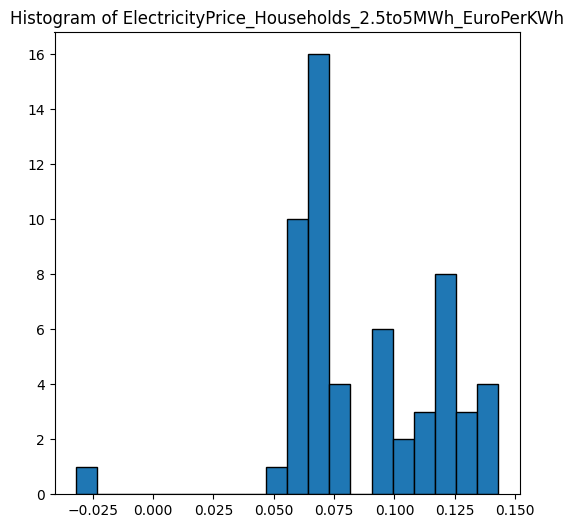

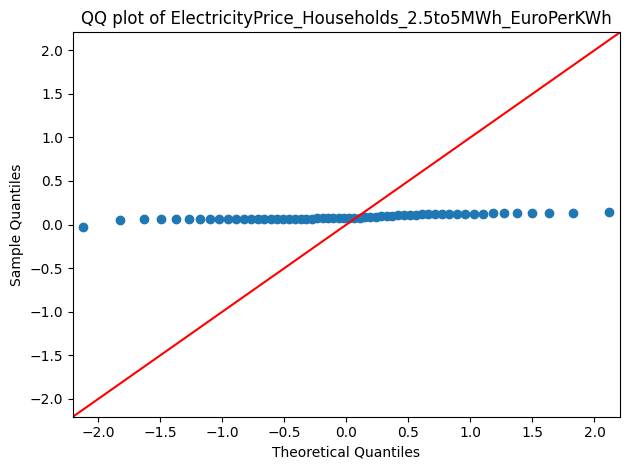

ShapiroResult(statistic=0.8810496926307678, pvalue=3.794524309341796e-05)


In [45]:
check_normality(df=energy_prices_processed, feature='ElectricityPrice_Households_2.5to5MWh_EuroPerKWh')

In [ ]:
energy_prices.isna().sum() / len(energy_prices)